# Predicting Restaurant Ratings

This notebook will combine the information about restaurants and the processed text from reviews and perform machine learning algorithms to make predictions about ratings based on the restaurants' features and reviews.
The analysis will focus on restaurants from Phoenix, Arizona, as this represents a compact data set with approx. 3,500 restaurants and just over 300,000 reviews about them. The analysis involves the following steps:
1. Importing the raw data from the _'business.json'_ file, filtering for restaurants in Phoenix, AZ, and converted to a pandas DataFrame format
2. Extracting features of each business for analysis
3. Importing the reviews from the _'review.json'_ file and converting each review to a vector, to be used with the already trained word2vec model
4. Sentiment modeling - this involves two parts: first, a training set of reviews will be used for supervised learning of the reviews' sentiment (positive or negative), using the star ratings as labels. Then the entiment will be predicted on a test set and its accuracy scored against the actual ratings. A variety of prediction models will be tested, including random forest and neural networks (MLPC).
5. Predicting actual star ratings based on the text of a review using a number of classifier models: random forest, ada boost and MLPC.
6. Visualising star rating predictions in 2-dimensional space, using t-SNE dimensionality reduction



# 1. Importing Restaurant  Data

In [4]:
import pandas as pd
import numpy as np
import json

In [5]:
# import raw data from json in the first run and save to .csv file
# for new runs load data directly from a .csv file to speed up the process 
if 0 == 1:
    businesses_df = pd.read_json('data/dataset/business.json', lines=True)
    businesses_df['restaurants'] = businesses_df['categories'].apply(lambda x: 'Restaurants' in x)
    restaurants_df = businesses_df[businesses_df['restaurants'] == True]
    restaurants_df.to_csv('data/restaurants.csv', encoding='utf-8')

else:
    restaurants_df = pd.read_csv('data/restaurants.csv', encoding='utf-8')

In [6]:
restaurants_df = restaurants_df.drop(['Unnamed: 0', 'restaurants'], axis=1)
restaurants_df.shape

(51613, 15)

In [7]:
restaurants_df.head(2)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,2824 Milton Rd,"{u'GoodForMeal': {u'dessert': False, u'latenig...",mLwM-h2YhXl2NCgdS84_Bw,"[Food, Soul Food, Convenience Stores, Restaura...",Charlotte,"{u'Monday': u'10:00-22:00', u'Tuesday': u'10:0...",0,35.236870,-80.741976,South Florida Style Chicken & Ribs,Eastland,28215,4,4.5,NC
1,4719 N 20Th St,"{u'GoodForMeal': {u'dessert': False, u'latenig...",duHFBe87uNSXImQmvBh87Q,"[Sandwiches, Restaurants]",Phoenix,{},0,33.505928,-112.038847,Blimpie,NaN,85016,10,4.5,AZ


In [8]:
restaurants_df.columns

Index([u'address', u'attributes', u'business_id', u'categories', u'city',
       u'hours', u'is_open', u'latitude', u'longitude', u'name',
       u'neighborhood', u'postal_code', u'review_count', u'stars', u'state'],
      dtype='object')

Data required is now loaded as restaurants_df data frame. The line below shows the structure of data by state - first Arizona (AZ) was selected as having a large data set of 10,000+ restaurants, and then Phoenix with 3,500+ restaurants. Choosing a single city with a wealth of data means that restaurants are comparable to each other and that meaningful conclusions can be drawn. However, the analysis can be easily expanded in scope to include other cities / states. Additionally, avoiding e.g. Quebec means that the analysis is limited to English language reviews.

In [9]:
by_state = restaurants_df.groupby('state')['stars'].count()
by_state

state
01         6
3          1
ABE        1
AZ     10219
BW      1759
BY         3
C         23
CA         1
EDH     1396
ELN       19
ESX        3
FIF       27
HH         1
HLD       60
IL       598
KHL        1
MLN       92
NC      3625
NI         8
NV      6883
NY        11
NYK       12
OH      4513
ON     12634
PA      3435
PKN        1
QC      4567
RCC        1
SC       201
ST         4
WA         1
WHT        1
WI      1486
WLN       18
XGL        1
ZET        1
Name: stars, dtype: int64

In [10]:
by_state.shape

(36L,)

In [11]:
arizona = restaurants_df.loc[restaurants_df.state == 'AZ']
phoenix = arizona.loc[arizona.city == 'Phoenix']
phoenix.shape

(3515, 15)

In [12]:
phoenix.groupby('postal_code')['review_count'].sum().sum()

302259L

In [13]:
phoenix.review_count.sum()

302400L

In [14]:
# save id's as set for faster searching
phx_ids = set(phoenix.business_id)
type(phx_ids)

set

The Phoenix restaurants are contained in the 'phoenix' data frame and the related business id data is kept in the 'phx-ids' set to be used when loading reviews.

In [15]:
import matplotlib.pyplot as plt
% matplotlib inline

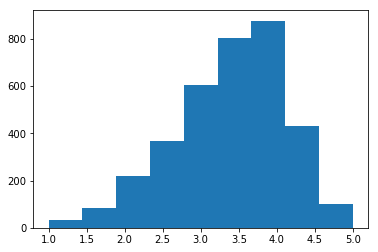

In [16]:
stars_rating = phoenix.stars
#log_stars = np.log(stars_rating)
plt.hist(phoenix.stars, bins=9)
plt.show()

In [17]:
phoenix.stars.value_counts()

4.0    877
3.5    804
3.0    603
4.5    431
2.5    368
2.0    218
5.0    100
1.5     82
1.0     32
Name: stars, dtype: int64

In [18]:
phoenix.stars.count()

3515

In [19]:
high_ratings = phoenix.stars[phoenix.stars >= 4]
low_ratings = phoenix.stars[phoenix.stars <= 2]
print high_ratings.count() / 3515.0
print low_ratings.count() / 3515.0

0.400568990043
0.0944523470839


# 2. Extracting Business Features 

The code below extracts data from the 'business.json' file and converts into a pandas data frame  using the json_normalize function. This will form the features matrix for machine learniong algorithms. Items such as parking, ambience and food choice are included. The json_normalize function extracts all the information in one step for each line of the json file. 

In [25]:
from pandas.io.json import json_normalize
import codecs
import os
#import jsonlines

In [26]:
%%time

# set the file path
business_json_filepath = os.path.abspath('data/dataset/business.json')

# initiate empty data frame
featuresdf = pd.DataFrame(zip([],[]))

# extract info line by line for each 
with codecs.open(business_json_filepath, encoding='utf_8') as f:
    for line in f:
        business = json.loads(line)
        bus_id = business[u'business_id'] 
        if bus_id not in phx_ids:
            continue
        norm = json_normalize(business) 

        featuresdf = featuresdf.append(norm)
        

Wall time: 2min 3s


In [27]:
featuresdf.shape

(3515, 93)

In [28]:
featuresdf.head(2)

,address,attributes.AcceptsInsurance,attributes.AgesAllowed,attributes.Alcohol,attributes.Ambience.casual,attributes.Ambience.classy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.intimate,attributes.Ambience.romantic,...,hours.Wednesday,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,4719 N 20Th St,NaN,NaN,none,False,False,False,False,False,False,...,NaN,0,33.505928,-112.038847,Blimpie,,85016,10,4.5,AZ
0,"2641 N 44th St, Ste 100",NaN,NaN,none,True,False,False,False,False,False,...,10:00-22:00,1,33.478043,-111.986370,Five Guys,,85008,63,3.5,AZ


In [29]:
featuresdf.columns

Index([u'address', u'attributes.AcceptsInsurance', u'attributes.AgesAllowed',
       u'attributes.Alcohol', u'attributes.Ambience.casual',
       u'attributes.Ambience.classy', u'attributes.Ambience.divey',
       u'attributes.Ambience.hipster', u'attributes.Ambience.intimate',
       u'attributes.Ambience.romantic', u'attributes.Ambience.touristy',
       u'attributes.Ambience.trendy', u'attributes.Ambience.upscale',
       u'attributes.BYOB', u'attributes.BYOBCorkage',
       u'attributes.BestNights.friday', u'attributes.BestNights.monday',
       u'attributes.BestNights.saturday', u'attributes.BestNights.sunday',
       u'attributes.BestNights.thursday', u'attributes.BestNights.tuesday',
       u'attributes.BestNights.wednesday', u'attributes.BikeParking',
       u'attributes.BusinessAcceptsBitcoin',
       u'attributes.BusinessAcceptsCreditCards',
       u'attributes.BusinessParking.garage', u'attributes.BusinessParking.lot',
       u'attributes.BusinessParking.street',
       u'at

# 3. Importing Reviews Data

In [30]:
# extract reviews data from the json file and store to data frame
review_json_filepath = os.path.abspath('data/dataset/review.json')

biz_data = []
rating_data = []
review_data = []


with codecs.open(review_json_filepath, encoding='utf_8') as f:
    for line in f:
        business = json.loads(line)
        bus_id = business[u'business_id'] 
        # filter restaurants in Phoenix
        if bus_id not in phx_ids:
            continue
        biz_data.append(bus_id)
        rating_data.append(business[u'stars'])
        review_data.append(business[u'text'])

print len(biz_data)
print len(rating_data)
print len(review_data)

302403
302403
302403


In [31]:
reviews_df = pd.DataFrame(zip(biz_data, rating_data, review_data))
reviews_df.columns = ['business_id', 'stars_rating', 'review']
reviews_df.head(10)

,business_id,stars_rating,review
0,_mqUzNXs_sJ1EJYgYZYszg,4,A really good sandwich place. It's location is...
1,_mqUzNXs_sJ1EJYgYZYszg,5,The food was definitely solid but what stood o...
2,_mqUzNXs_sJ1EJYgYZYszg,4,Great place to grab lunch. The location is a l...
3,_mqUzNXs_sJ1EJYgYZYszg,5,"What a find, right behind the Radisson, fresh ..."
4,_mqUzNXs_sJ1EJYgYZYszg,5,I work in a office building right around the c...
5,_mqUzNXs_sJ1EJYgYZYszg,3,I can't figure out why their food isn't that g...
6,_mqUzNXs_sJ1EJYgYZYszg,4,"Only open for lunch spot, a nice little sandwi..."
7,_mqUzNXs_sJ1EJYgYZYszg,5,After arriving at PHX airport we searched for ...
8,_mqUzNXs_sJ1EJYgYZYszg,3,I have visited The Lunch Lounge 3 times since ...
9,_mqUzNXs_sJ1EJYgYZYszg,5,"Happy to have found this place! Great food, de..."


Reviews data stored in 'reviews_df' data frame and includes business id, stars rating and revew text. Line below extracts one sample review text (stored as unicode):

In [32]:
reviews_df.review[299522]

u'I absolutely always enjoy the jade red chicken.  A little disappointed they do not have egg rolls but the heat selection of Asian beers definitely make up for it'

In [33]:
# mean of the ratings
reviews_df.stars_rating.mean()

3.803288988535167

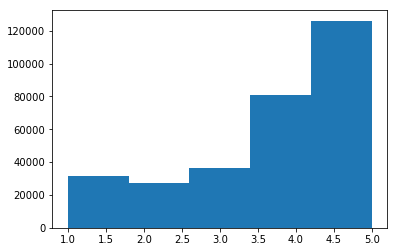

In [34]:
# histogram of individual ratings
plt.hist(reviews_df.stars_rating, bins=5)
plt.show()

# 4. Sentiment Modeling

## 4.1. Importing the Trained NLP Model

We now have two data frames for the set of approx. 3500 restaurant businesses in Phoenix. - one with business information and one containing 300,000+ reviews about them. 

The next step uses the NLP model (already trained on the entire dataset of 2.9 million reviews) to extract summary information from the reviews about each business and add this information to the features matrix.

The model will be imported as a gensim word2vec model and each review will be converted to a feature vector. As reviews vary in length, a method is needed to obtain a representative feature vector for each review in the same format. The solution used here is to generate a feature vector for each word in the review (in its lemma form, excluding punctuation, white space and stop words), add vectors for all words in the review, and divide by the number of words. This will create an average feature vector that is a representation of the broad meaning of the review.

In [35]:
# this is to access the file where the ENglish language model is located
import sys
sys.path.append('C:\Windows\System32\.env\Lib\site-packages')

In [36]:
# import spact for processing text in reviews
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load() 

In [37]:
# import gensime module to use word2vec model created
from gensim.models import Word2Vec

C:\Users\Work\Anaconda2\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [38]:
# import the trained word2vec model
model = Word2Vec.load('data/intermediate/word2vec_model_all')

In [39]:
# create set of words in word2vec model
index2word_set = set(model.wv.index2word)

In [40]:
# show feature vector for selected words
model['excellent']

array([ 0.44177014,  0.34545311, -0.4863095 ,  0.35393116,  0.20394039,
        0.32689789, -0.04189698,  0.09583075,  0.59013194,  0.13289815,
       -0.43105602,  0.4870742 , -0.16222502, -0.2792412 ,  0.29100522,
       -0.23376985, -0.16161127, -0.33476841,  0.11884616, -0.02219654,
       -0.06832016,  0.18777724, -0.31993359,  0.41420466,  0.02011142,
        0.34190252, -0.02196711,  0.16111246, -0.16246185,  0.0499949 ,
       -0.19975521, -0.16161473,  0.17163743, -0.22013833,  0.23611847,
       -0.27877772, -0.37166238,  0.0329407 ,  0.58188915,  0.24307698,
        0.4378143 ,  0.02364679, -0.20428382,  0.06199164,  0.05651153,
       -0.15151869,  0.58012015, -0.288416  ,  0.45948359,  0.33597344,
        0.13952601, -0.23661782, -0.20378302,  0.42699447, -0.07695791,
       -0.21763811, -0.12416524,  0.39530164,  0.24426317, -0.08625464,
        0.01122354,  0.07476675,  0.07364706,  0.05514677,  0.03141041,
       -0.44871995, -0.64922386,  0.27328208, -0.46428677, -0.07

In [41]:
# smaller data set to test model
smalldf = reviews_df.head(3100)

In [42]:
def punct_space_stop(token):
    """
    helper function to eliminate tokens
    that are pure punctuation, whitespace and stop words
    """
    
    return token.is_punct or token.is_space or token.is_stop


In [44]:
def makeFeatureVec(words, model, num_features):
    """
    Function to average all of the word vectors in a review
    """
    # process the unicode input text to tokens
    nlp_words = nlp(words)
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in nlp_words:
        if not punct_space_stop(word):
            # convert to lemma and unicode 
            uw = unicode(word.lemma_)
            if uw in index2word_set: 
                nwords = nwords + 1.
                featureVec = np.add(featureVec,model[uw])
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec

In [45]:
def getAvgFeatureVecs(reviews, model, num_features):
    """
    Function to calculate the average feature vector for each 
    review given a list of reviews and return a 2D numpy array. 
    If list of reviews is a pandas DataFrame column, a slice of the column 
    needs to be fed into the function and not simply the column name
    """
    # Initialize a counter
    counter = 0
    # 
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    # 
    # Loop through the reviews and update progress everu 1000 reviews
    for review in reviews:
        # keep track of progress
        if counter%10000 == 0:
            print "Review %d of %d" % (counter, len(reviews)) 
            
        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
       
        # Increment the counter
        counter = counter + 1
    return reviewFeatureVecs


## 4.2. Random Forest Classifier 

The first attemt to classify data will use a random forest model. Paramneters to be tuned to optimize the model are: number of trees used, maximum tree depth, minimum items in a leaf. In addition the n_jobs parameter can be set to parallelize the process, using all 4 cores (importnat for the whole data set of 300k+ reviews).

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
# function to map star ratings to sentiment
# 1-2 stars: set to 0, 'negative review'
# 4-5 stars: set to 1, 'positive review'
# 3 stars: net to None and drop values at later stage, 'neutral review that is not useful for sentiment analysis'
def ratings_map(x):
    if x in [1,2]:
        xnew = 0
    elif x in [4,5]:
        xnew = 1
    else: 
        xnew = None
    return xnew

In [49]:
# add sentiment column to the entire data set (300k reviews)
reviews_df.loc[:,'sentiment'] = reviews_df.stars_rating.apply(lambda x: ratings_map(x))
reviews_df.shape

(302403, 4)

In [50]:
# drop the 3's and save to reviews_df1
reviews_df1 = reviews_df.dropna()
reviews_df1.shape

(265745, 4)

In [55]:
%%time
# create feature matrix X and results vector y
# for X need to extract feature vectors for all reviews in the large data set

if 0==1:
    X2 = getAvgFeatureVecs(reviews_df1.review[:], model, 100)
    # if the array contains NaN, convert to zero
    X21 = np.nan_to_num(X2) 
    np.save('X_matrix', X21)
    
else: 
    X21 = np.load('X_matrix.npy')
y2 = reviews_df1.sentiment

Wall time: 98 ms


In [56]:
# split data into training and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X21, y2, test_size=0.3)

In [57]:
%%time
# fit random forest model to training set
# use to predict sentiment on test set
# evaluate score as proportion of accurate predictions

forest2 = RandomForestClassifier(n_estimators = 500, n_jobs=4)
forest2 = forest2.fit(X2_train, y2_train)
result2 = forest2.predict(X2_test)
score = (result2 - y2_test) == 0
print float(score.sum())/len(score)

0.915997692038
Wall time: 13min 32s


Results:
- RandomForestClassifier(n_estimators = 500, n_jobs=4); score: 0.9157
- 

## 4.3. Neural Network Classifier 

The next part is an attempt to produce better prediction results using a neural network model on the same data. The model used is the Multi-layer Perceptron (MLP) classifier from the scikit-learn library. Further, a range of parameters will be tested in order to tune the model for optimal results.

In [58]:
from sklearn.neural_network import MLPClassifier

In [62]:
clf = MLPClassifier(solver='adam', alpha=1e-4, random_state=1)

In [63]:
clf.fit(X2_train, y2_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [64]:
clf_result = clf.predict(X2_test)
score = (clf_result - y2_test) == 0
print float(score.sum())/len(score)

0.94368069841


Results:
 - MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=1); score: 0.9400
 - MLPClassifier(solver='lbfgs', alpha=1e-4, random_state=1); score: 0.9406
 - MLPClassifier(solver='lbfgs', alpha=1e-3, random_state=1); score: 0.9397
 - MLPClassifier(solver='sgd', alpha=1e-4, random_state=1); score: 0.9360
 - MLPClassifier(solver='sgd', alpha=1e-4, random_state=1, learning_rate='adaptive'); score: 0.9362
 - MLPClassifier(solver='sgd', alpha=1e-4, random_state=1, learning_rate='invscaling'); score: 0.7796
 - MLPClassifier(solver='adam', alpha=1e-4, random_state=1); score: 0.9412 
 - MLPClassifier(solver='adam', alpha=1e-3, random_state=1); score = 0.9419 (this took much longer to run)

The standard MLP classifier, with default settings gives a prediction accuracy of 94.0%. Using different solvers and varying values of alpha (L2 regularization parameter that helps avoid overfitting) gave little variation in accuracy. The best result obtained was 94.2% using the 'adam' solver. According to the scikit-learn documentation, the 'adam' solver works relatively well on large data sets. The only outlier in the model is the 'sgd' solver with an inverse scaling learning rate, which only gave 78% accuracy.  

Overall, this model gave better results that the random forest model, with an increase in accuracy of approximately 2.5 percentage points.

# 5. Predicting Star Ratings

The previous section analyzed sentiment predictions for reviews as a positive (rating of 4 or 5 stars) or negative (rating of 1 or 2 stars). The 3-star reviews were ignored altogether. Using a random forest or MLP classifier bith gave good results with accuracy of 92% (random forest) and 94% (MLP). This is not surprising, as the elimination of 3-star reviews has provided a clearer separation of the two classes.

In the next section, we will try to predict the actual star rating of a review. In order to provide a more computationally manageable data set, the analysis will be performed on a slice of the original data, containing 50,000 reviews. A training set of 35,000 will be used to 'learn' the data, using 3 types of classifier:
- Random Forest
- Ada Boost
- MLP

The test sample of 15,000 reviews will be used to predict the data and obtain a prediction accuracy as the mean squared error (MSE). Further, we will look at the proportion of correct predictions for each model, and the proportion of 'bad' predictions (where the error is 2 or higher).

In [65]:
reviews_sample = reviews_df.loc[50000:99999,:]
reviews_sample.shape

(50000, 4)

In [67]:
if 0 ==1:
    X3 = getAvgFeatureVecs(reviews_sample.review[:], model, 100)
    np.save('X_matrix_classification', X3)
else: X3 = np.load('X_matrix_classification.npy')

In [68]:
y3 = reviews_sample.stars_rating.values
np.unique(y3, return_counts=True)

(array([1, 2, 3, 4, 5], dtype=int64),
 array([ 6250,  4850,  6347, 13318, 19235], dtype=int64))

In [69]:
# split data into training and test sets
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3)

In [70]:
from sklearn.metrics import mean_squared_error

In [71]:
# random forest classifier

rfc = RandomForestClassifier(n_estimators = 200, max_depth = 100, min_samples_leaf = 1, n_jobs=4)
rfc = rfc.fit(X3_train, y3_train)
result_rfc = rfc.predict(X3_test)
mse_rfc = mean_squared_error(y3_test, result_rfc)
correct_pred_rfc = (result_rfc - y3_test) == 0
print 'MSE on random forect classifier: ', mse_rfc
print 'Proportion of correct predictions: ', correct_pred_rfc.sum() / float(len(y3_test))

MSE on random forect classifier:  1.22633333333
Proportion of correct predictions:  0.540333333333


In [72]:
from sklearn.ensemble import AdaBoostClassifier

In [73]:
ada = AdaBoostClassifier(n_estimators = 100, random_state=1)
ada = ada.fit(X3_train, y3_train)
result_ada = ada.predict(X3_test)
mse_ada = mean_squared_error(y3_test, result_ada)
correct_pred_ada = (result_ada - y3_test) == 0
print 'MSE on Ada Boost classifier: ', mse_ada
print 'Proportion of correct predictions: ', correct_pred_ada.sum() / float(len(y3_test))              

MSE on Ada Boost classifier:  1.14113333333
Proportion of correct predictions:  0.533666666667


In [74]:
# MLPClassifier

mlpc = MLPClassifier(solver='adam', alpha=1e-4, random_state=1)
mlpc = mlpc.fit(X3_train, y3_train)
result_mlpc = mlpc.predict(X3_test)
mse_mlpc = mean_squared_error(y3_test, result_mlpc)
correct_pred_mlpc = (result_mlpc - y3_test) == 0
print 'MSE on MLP classifier: ', mse_mlpc
print 'Proportion of correct predictions: ', correct_pred_mlpc.sum() / float(len(y3_test))

MSE on MLP classifier:  0.876466666667
Proportion of correct predictions:  0.572733333333


In [75]:
# proportion of 'bad' predictions
bads_rfc = ((result_rfc - y3_test) >= 2).sum() / float(len(y3_test))
bads_ada = ((result_ada - y3_test) >= 2).sum() / float(len(y3_test))
bads_mlpc = ((result_mlpc - y3_test) >= 2).sum() / float(len(y3_test))

print 'Random forest classifier bad predictions: ', bads_rfc
print 'Ada Boost classifier bad predictions: ', bads_ada
print 'MLP classifier bad predictions: ', bads_mlpc


Random forest classifier bad predictions:  0.099
Ada Boost classifier bad predictions:  0.0672
MLP classifier bad predictions:  0.0554


In [76]:
# accurate predictions
acc_rfc = correct_pred_rfc.sum() / float(len(y3_test))
acc_ada = correct_pred_ada.sum() / float(len(y3_test))
acc_mlpc = correct_pred_mlpc.sum() / float(len(y3_test))

__Summary of Results__

In [77]:
results_summary = pd.DataFrame({'MSE': [mse_rfc, mse_ada, mse_mlpc],
                               'Accurate predictions': [acc_rfc, acc_ada, acc_mlpc],
                               'Bad predictions': [bads_rfc, bads_ada, bads_mlpc]})
results_summary.index = ['Random Forest', 'Ada Boost', 'MLP'] 
results_summary                               

,Accurate predictions,Bad predictions,MSE
Random Forest,0.540333,0.0990,1.226333
Ada Boost,0.533667,0.0672,1.141133
MLP,0.572733,0.0554,0.876467


For this clasification exercise, the MLP classifier gave the best results, with the lowest MSE, highest proportion of accurate predictions and lowest number of 'bad' predictions with an error >= 2. The Ada Boost and random forest models were equal in accurate predictions, but Ada Boost outperformed the random forest model by having fewer 'bad' predictions, resulting in a lower mean squared error. 

A possible further improvement of the neural network classifier would be to use a deep learning model, e.g. using the keras package.

# 6. Visualising Classification Results

In [78]:
from sklearn.manifold import TSNE

In [79]:
from sklearn.decomposition import PCA

In [80]:
pca = PCA(n_components=2)
pca_vectors = pca.fit_transform(X3)

In [81]:
pca.explained_variance_ 

array([ 0.07562994,  0.04948046], dtype=float32)

In [82]:
# reduce the set to 500 data points from the test set, for easier dimensionality reduction and visualisation
Xtest = X3_test[:500]
Xtest.shape

(500L, 100L)

In [83]:
# use t-SNE for dimensionality reduction to 2D
tsne = TSNE()
tsne_vectors = tsne.fit_transform(Xtest)
coords = tsne.embedding_

In [84]:
# assemble relevant arrays in a data frame
x_coord = coords[:, 0]
y_coord = coords[:, 1]
true_labels = y3_test[:500]
mlpc = result_mlpc[:500]
ada = result_ada[:500]
rf = result_rfc[:500]
results_df = pd.DataFrame(zip(x_coord, y_coord, true_labels, mlpc, ada, rf))
results_df.columns = ['x_coord', 'y_coord', 'true_labels', 'mlpc_labels', 'ada_labels', 'rf_labels']
results_df.tail(20)

,x_coord,y_coord,true_labels,mlpc_labels,ada_labels,rf_labels
480,-3.804321,4.707441,5,5,5,5
481,-12.070126,-1.330015,5,5,5,5
482,0.727990,7.378148,5,2,1,5
483,-13.206208,1.465818,5,4,5,4
484,-13.284616,1.367914,4,4,4,4
485,-1.743398,-1.995149,5,5,5,5
486,5.917442,-2.263778,4,5,4,4
487,-7.411382,6.321702,4,4,5,5
488,0.101799,4.075646,2,4,5,5
489,-2.044399,4.126488,5,5,5,5


In [85]:
results_df.to_csv('data/2dresults.csv')

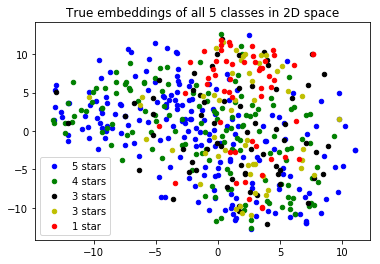

In [86]:
plt.scatter(x = results_df.loc[results_df['true_labels'] == 5].x_coord, 
            y = results_df.loc[results_df['true_labels'] == 5].y_coord, c='b', s=20, label='5 stars')
plt.scatter(x = results_df.loc[results_df['true_labels'] == 4].x_coord, 
            y = results_df.loc[results_df['true_labels'] == 4].y_coord, c='g', s=20, label='4 stars')
plt.scatter(x = results_df.loc[results_df['true_labels'] == 3].x_coord, 
            y = results_df.loc[results_df['true_labels'] == 3].y_coord, c='k', s=20, label='3 stars')
plt.scatter(x = results_df.loc[results_df['true_labels'] == 2].x_coord, 
            y = results_df.loc[results_df['true_labels'] == 2].y_coord, c='y', s=20, label='3 stars')
plt.scatter(x = results_df.loc[results_df['true_labels'] == 1].x_coord, 
            y = results_df.loc[results_df['true_labels'] == 1].y_coord, c='r', s=20, label='1 star')
plt.legend()
plt.title('True embeddings of all 5 classes in 2D space')
plt.show()

Due to the large number of features, the 2-D representation does not show clear boundaries between the classes. Charts below show the positioning of 5-star and 1-star classes (two classes that are the most different from each other). The MLPC model misclassifies between these two labels (true 5 predicted as 1, and true 1 predicted as 5) in <1% of cases. 

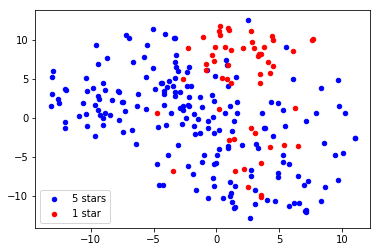

In [87]:
plt.scatter(x = results_df.loc[results_df['true_labels'] == 5].x_coord, 
            y = results_df.loc[results_df['true_labels'] == 5].y_coord, c='b', s=20, label='5 stars')

plt.scatter(x = results_df.loc[results_df['true_labels'] == 1].x_coord, 
            y = results_df.loc[results_df['true_labels'] == 1].y_coord, c='r', s=20, label='1 star')
plt.legend()
plt.show()

Looking at 5-star ratings only, we can visualise which points are correctly/falsely predicted by the MLPC model...

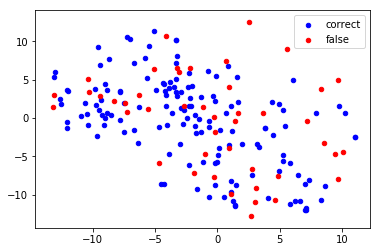

In [88]:
# 5-star correct and false predictions using MLPC
plt.scatter(x = results_df.loc[(results_df['true_labels'] == 5) & (results_df['mlpc_labels'] == 5)].x_coord, 
            y = results_df.loc[(results_df['true_labels'] == 5) & (results_df['mlpc_labels'] == 5)].y_coord, 
            c='b', s=20, label='correct')

plt.scatter(x = results_df.loc[(results_df['true_labels'] == 5) & (results_df['mlpc_labels'] != 5)].x_coord, 
            y = results_df.loc[(results_df['true_labels'] == 5) & (results_df['mlpc_labels'] != 5)].y_coord, 
            c='r', s=20, label='false')

plt.legend()
plt.show()

... and we can view the same results for 1-star ratings. The results seem to show that points on the fringes are corectly predicted, and the false ratings tend to fall in the middle of the chart, which is harder to distinguish from other classes.

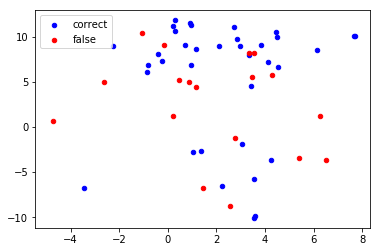

In [89]:
# 1-star correct and false predictions using MLPC
plt.scatter(x = results_df.loc[(results_df['true_labels'] == 1) & (results_df['mlpc_labels'] == 1)].x_coord, 
            y = results_df.loc[(results_df['true_labels'] == 1) & (results_df['mlpc_labels'] == 1)].y_coord, 
            c='b', s=20, label='correct')

plt.scatter(x = results_df.loc[(results_df['true_labels'] == 1) & (results_df['mlpc_labels'] != 1)].x_coord, 
            y = results_df.loc[(results_df['true_labels'] == 1) & (results_df['mlpc_labels'] != 1)].y_coord, 
            c='r', s=20, label='false')

plt.legend()
plt.show()